# Projet TensorFlow
#### SALMON Loïck et HENDRICÉ Rémy
## Première Partie - Classification d'images

In [6]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

### 1. Chargement du dataset

In [7]:
(base_training_dataset, base_validation_dataset), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    as_supervised = True
)

### 2. Description du DataSet

2024-06-15 18:27:13.030314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


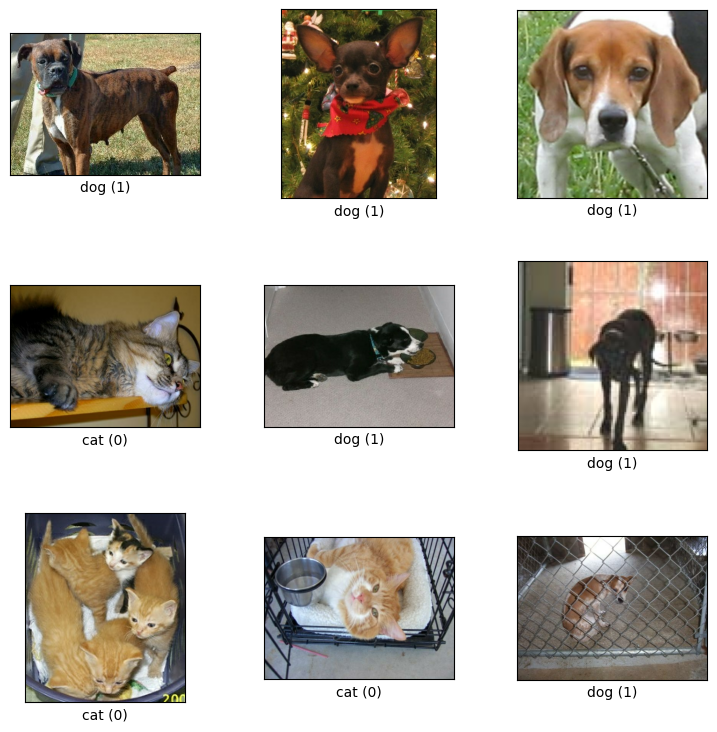

23262


In [8]:
tfds.show_examples(base_training_dataset, info)
print(len(base_training_dataset) + len(base_validation_dataset))

Nous avons 23262 images pour l'apprentissage. Ce sont des images rectangulaires, chacune de dimensions différentes, en couleurs.
Il y a deux classes : chien (1) ou chat (0)

### 3. Déterminer les paramètre de taille d'image, du nombre de neurons en entrée et la taille du batch

Pour cette exercice, nous avons choisi d'utiliser des images carrées car cela simplifie le traitement. Nous avons choisi une taille de 128x128 pixels.

Le nombre d'entrées est directement lié à la taille des images. Chaque valeur R,G,B correspond à une entrée. Il y a donc 128\*128\*3 = 49152 entrées.

Pour le batch, nous avons choisi une taille de 32. Cela permet de ne pas surcharger la mémoire tout en permettant un apprentissage efficace.

In [9]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

### 4. Répartition du dataset

Nous avons dédié 80% du dataset à l'entraînement et 20% à la validation comme conseillé dans la documentation TensorFlow https://www.tensorflow.org/tutorials/images/classification#load_data_using_a_keras_utility

> It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.



### 5. Normalisation des données

Nous pouvons redimensionner nos images avec une couche Resizing dans notre modèle

In [10]:
resizing_layer = layers.Resizing(IMAGE_SIZE,IMAGE_SIZE, name='Resizing')

Nous utilisons une couche Rescaling pour normaliser les valeurs de pixels de 0 à 255 à un intervalle de 0 à 1.


In [11]:
rescaling_layer = layers.Rescaling(1./255, name='Rescaling')

In [12]:
def preprocess(image, label):
    image = resizing_layer(image)
    image = rescaling_layer(image)
    return image, label

training_dataset = base_training_dataset.map(preprocess)
validation_dataset = base_validation_dataset.map(preprocess)
training_dataset = training_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


### 6. Création du réseau de neurones

Pour le réseau de neurones, nous allons appliquer nos couches de resizing et de rescaling puis nous allons appliquer notre réseau de convolution.

In [13]:
model = keras.Sequential([
    layers.InputLayer((IMAGE_SIZE,IMAGE_SIZE,3), name='Input'),
    layers.Conv2D(16,3,padding='same', activation='relu',name='First-Conv'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='same', activation='relu',name='Second-Conv'),
    layers.MaxPool2D()
])

In [14]:
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))

De là, on construit le modèle

In [15]:
model.compile(optimizer = 'adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )


In [16]:
max_epoch = 10
history = model.fit(training_dataset, epochs=max_epoch,
                    validation_data=validation_dataset)


Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 61s 103ms/step - accuracy: 0.6132 - loss: 0.6836 - val_accuracy: 0.7328 - val_loss: 0.5303
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 58s 100ms/step - accuracy: 0.7630 - loss: 0.4932 - val_accuracy: 0.7491 - val_loss: 0.5046
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - accuracy: 0.8020 - loss: 0.4309 - val_accuracy: 0.7635 - val_loss: 0.5088
Epoch 4/10
394/582 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.8277 - loss: 0.3862

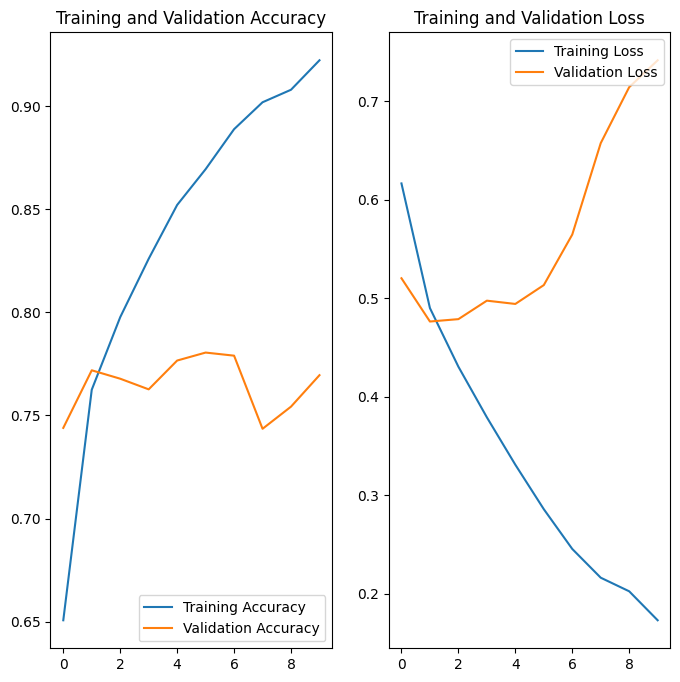

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### 7. Discussion des résultats obtenus

L'apprentissage s'exécute en plus ou moins 15 minutes, environ 1.5 minutes par epoch. On pourrait diminuer ce temps en diminuant encore plus la taille des images, mais cela pourrait impacter la qualité de notre modèle.

On observe sur les courbes 'accuracy' que la précision sur le jeu d'apprentissage approche 100% tandis que celle du jeu de validation stagne entre 70 et 75%.
De plus, la courbe de 'loss' pour l'apprentissage est très bonne et tend vers une valeur proche de 0 (à vue d'oeil environ 0.1) tandis que la courbe pour la validation ne fait que grimper. 

Il semble y avoir de l'overfitting ici, notre modèle est très bon pour prédire sur les données d'apprentissage mais pas sur celles de validation. Le modèle ne se généralise pas bien car son apprentissage a été configuré pour qu'il prédise des images forts semblables à celles d'entraînement.

Nous pourrions essayer de diminuer le nombre d'epochs pour éviter ce phénomène.

In [ ]:
def create_model(nb_couches_convo):
    catdogs_model = keras.Sequential([
        layers.InputLayer((IMAGE_SIZE,IMAGE_SIZE,3), name='Input'),
    ])

    conv_size = 0

    for i in range(nb_couches_convo):
        conv_size = 16 * (2**i)
        catdogs_model.add(layers.Conv2D(conv_size,3,padding='same', activation='relu',name=f'Conv_{i}'))
        catdogs_model.add(layers.MaxPool2D())

    catdogs_model.add(layers.Flatten())
    catdogs_model.add(layers.Dense(conv_size * 2, activation='relu'))
    catdogs_model.add(layers.Dense(2))

    catdogs_model.compile(optimizer = 'adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )
    return catdogs_model

Essayons un modèle avec une couche de convolution en plus et s'arrêtant après 5 itérations.

In [ ]:
max_epoch = 10
model_v2 = create_model(3)
history = model_v2.fit(training_dataset, epochs=max_epoch,
                    validation_data=validation_dataset)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 88s 149ms/step - accuracy: 0.5913 - loss: 0.6665 - val_accuracy: 0.7173 - val_loss: 0.5451
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 88s 150ms/step - accuracy: 0.7514 - loss: 0.5052 - val_accuracy: 0.7771 - val_loss: 0.4705
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 87s 149ms/step - accuracy: 0.8168 - loss: 0.4049 - val_accuracy: 0.8188 - val_loss: 0.3980
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 86s 148ms/step - accuracy: 0.8544 - loss: 0.3344 - val_accuracy: 0.8177 - val_loss: 0.4046
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 85s 146ms/step - accuracy: 0.8895 - loss: 0.2663 - val_accuracy: 0.8117 - val_loss: 0.4263


In [ ]:
def show_history(history, max_epoch):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(max_epoch)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

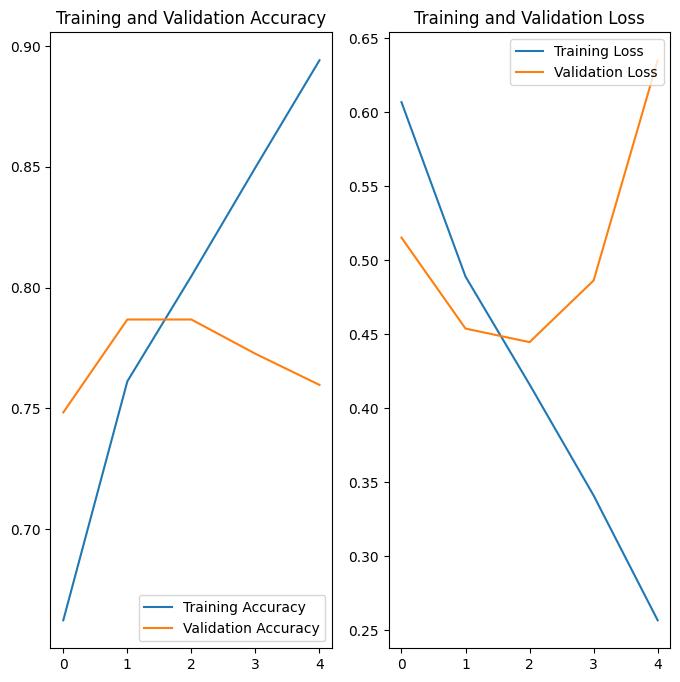

In [ ]:
show_history(model_v2.history, max_epoch)

On voit ici qu'après l'epoch 2 (la troisième donc), le modèle ne s'améliore plus pour la validation, au contraire il régresse.

Essayons maintenant avec une couche de convolution supplémentaire.

In [ ]:
model_v3 = create_model(4)
max_epoch = 10
history = model_v3.fit(training_dataset, epochs=max_epoch,
                    validation_data=validation_dataset)


Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 117s 198ms/step - accuracy: 0.5611 - loss: 0.6777 - val_accuracy: 0.7190 - val_loss: 0.5373
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7294 - loss: 0.5353

KeyboardInterrupt: 

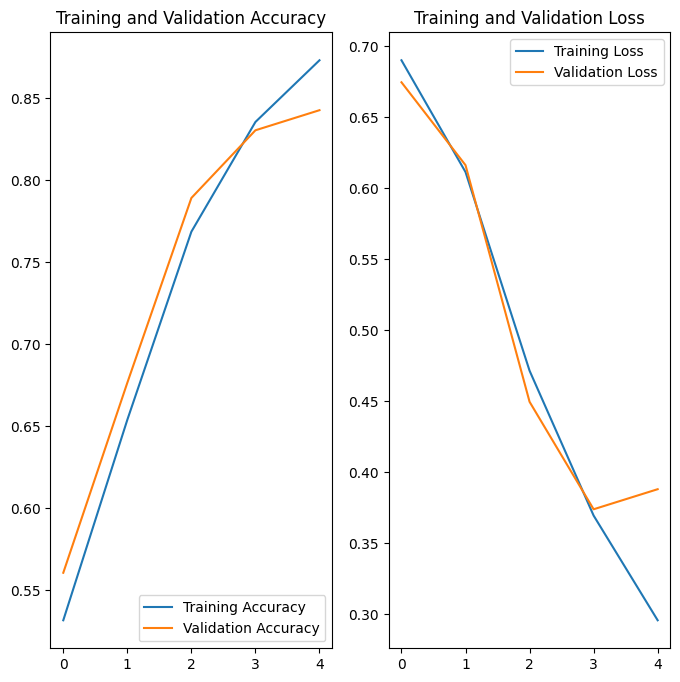

In [ ]:
show_history(history, max_epoch)

Le modèle a l'air de mieux se généraliser. Les courbes de précision et de perte de validation tendent vers les courbes d'apprentissage, ce qui est très bon signe.

In [ ]:
model_v4 = create_model(5)
history = model_v4.fit(training_dataset, epochs=max_epoch,
                    validation_data=validation_dataset)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 106s 179ms/step - accuracy: 0.5227 - loss: 0.6935 - val_accuracy: 0.5606 - val_loss: 0.6745
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 104s 178ms/step - accuracy: 0.6126 - loss: 0.6454 - val_accuracy: 0.6765 - val_loss: 0.6162
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 104s 179ms/step - accuracy: 0.7502 - loss: 0.5047 - val_accuracy: 0.7891 - val_loss: 0.4496
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 104s 178ms/step - accuracy: 0.8229 - loss: 0.3906 - val_accuracy: 0.8304 - val_loss: 0.3739
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 104s 179ms/step - accuracy: 0.8655 - loss: 0.3110 - val_accuracy: 0.8426 - val_loss: 0.3881


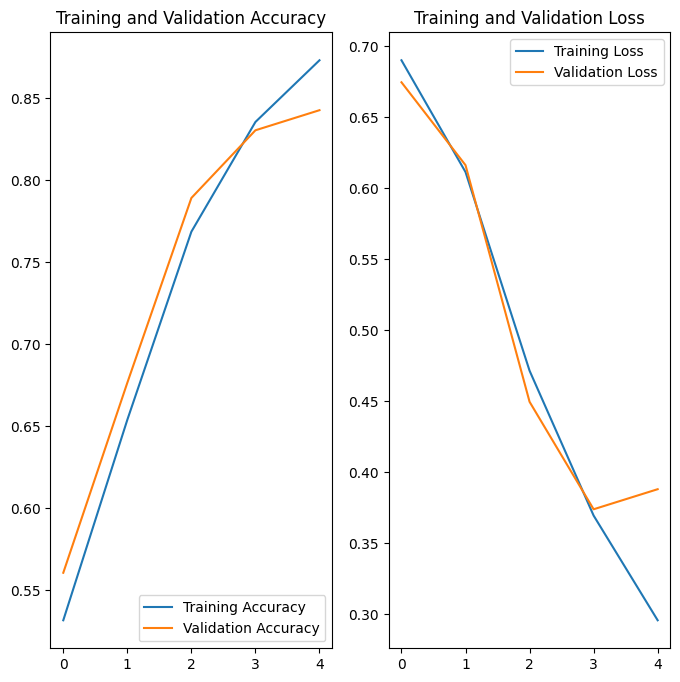

In [ ]:
show_history(history, max_epoch)

L'apprentissage est encore meilleur avec 5 couchess de convolution.

### 8. Prédiction avec des image personnelles

In [ ]:
import os
import math

def predict_images(model):
    dir = './images'
    class_names=['chat','chien']

    files_in_dir = list(os.listdir(dir))
    subplot_dim = math.ceil(math.sqrt(len(files_in_dir)))
    for (i, img_name) in enumerate(files_in_dir):

        img_path = f'{dir}/{img_name}'
        img = tf.keras.utils.load_img(
            img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        plt.subplot(subplot_dim,subplot_dim,i+1)
        plt.imshow(img)
        plt.title(class_names[np.argmax(score)])
        plt.axis("off")
        #print(
        #    f"L'image {img_name} est un {class_names[np.argmax(score)]}" # with a {100 * np.max(score):.2f} percent confidence."
        #")
    plt.show()


#### Premier modèle
- 2 couches de convolutions
- 10 epochs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


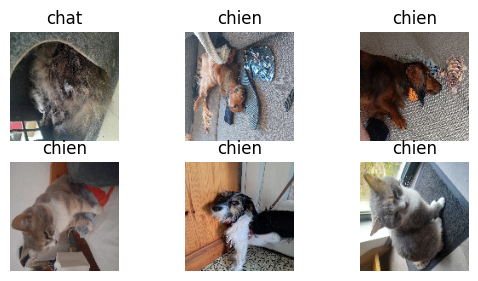

In [ ]:
predict_images(model)

#### Deuxième Modèle
- 3 couches de convolutions
- 5 epochs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


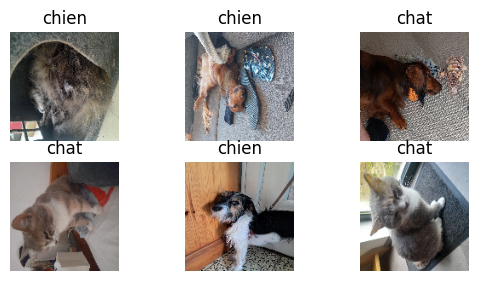

In [ ]:
predict_images(model_v2)

#### Troisième modèle
- 4 couches de convolutions
- 5 epochs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


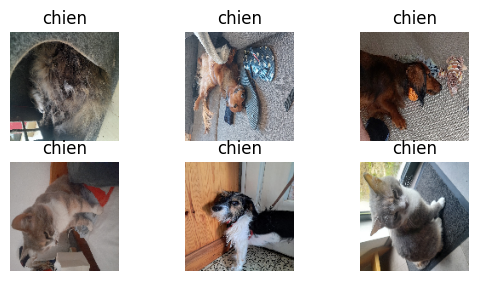

In [ ]:
predict_images(model_v3)


#### Quatrième modèle
- 5 couches de convolutions
- 5 epochs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


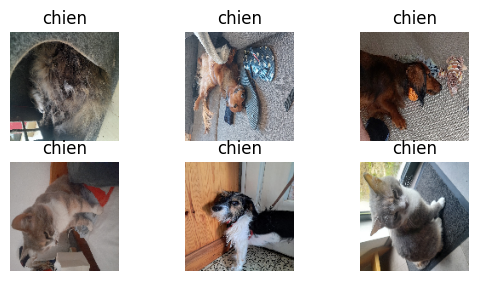

In [ ]:
predict_images(model_v4)

## Deuxième Partie - Transfer learning

### 1. Charger le modèle MobileNetv2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top=False)
base_model.trainable = False
#base_model.summary()

NameError: name 'tf' is not defined

En enlevant la dernière couche, on obtient la sortie du réseau de convolution.

### 2. Rajouter une couche de classification

In [ ]:
dense = layers.Dense(1, activation="sigmoid")

base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ input_layer_24[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, None,      │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### 3. Ajout d'une couche de dropout

La couche dropout permet d'éviter l'overfitting en mettant à 0 aléatoirement plusieurs valeurs d'un input à une certaine fréquence et en multipliant les autres valeurs non nullifiées par $\frac {1} {1-frequence}$ pour conserver le total des valeurs intact.

Elle n'a d'effet que si les couches qu'elle précède sont marquées "trainable", il serait donc logique de l'insérer avant la couche Dense précédemment créée.

In [ ]:
input_lyr = keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
x = base_model(input_lyr, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
output = dense(x)
updated_model = keras.Model(input_lyr, output)

updated_model.summary()

Model: "functional_300"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 4. Discussion sur l'apprentissage

In [ ]:
#updated_model.build()
updated_model.compile(optimizer = 'adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [ ]:
base_learning_rate = 0.0001
updated_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

updated_model.summary()

Model: "functional_300"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
rescaling_layer = layers.Rescaling(1./127, offset=-1, name='Rescaling')

training_dataset = base_training_dataset.map(preprocess)
validation_dataset = base_validation_dataset.map(preprocess)
training_dataset = training_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


In [ ]:
updated_model.fit(training_dataset, epochs=max_epoch,
                    validation_data=validation_dataset)

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 104s 172ms/step - accuracy: 0.9627 - loss: 0.0909 - val_accuracy: 0.9656 - val_loss: 0.0902
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 103s 177ms/step - accuracy: 0.9648 - loss: 0.0886 - val_accuracy: 0.9665 - val_loss: 0.0894
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 102s 174ms/step - accuracy: 0.9652 - loss: 0.0855 - val_accuracy: 0.9669 - val_loss: 0.0894
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 102s 176ms/step - accuracy: 0.9642 - loss: 0.0864 - val_accuracy: 0.9665 - val_loss: 0.0892
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 106s 182ms/step - accuracy: 0.9675 - loss: 0.0835 - val_accuracy: 0.9663 - val_loss: 0.0889
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 107s 184ms/step - accuracy: 0.9687 - loss: 0.0825 - val_accuracy: 0.9658 - val_loss: 0.0885
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 108s 185ms/step - accuracy: 0.9680 - loss: 0.0846 - val_accuracy: 0.9663 - val_loss: 0.0881
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 105s 181ms/step - accuracy: 0.9690 -

In [ ]:
show_history(updated_model.history, max_epoch)
updated_model.summary()

NameError: name 'show_history' is not defined

### 5. Comparaison des performances

On obtient un modèle qui, dès la première epoch, a une précision et une perte quasi parfaites (proches de 1 et 0 respectivement)

### 6. Comment améliorer notre apprentissage ?

Premièrement, nous pourrions déjà ajouter une couche Dropout pour éviter le risque d'overfitting.

De plus, le modèle MobileNetv2 possède 53 couches de convolutions, ce qui améliore d'autant plus sa qualité.

### 7. Prédictions

In [ ]:
def predict_images_mobile(model):
    dir = './images'
    class_names=['chat','chien']

    files_in_dir = list(os.listdir(dir))
    subplot_dim = math.ceil(math.sqrt(len(files_in_dir)))
    
    for (i, img_name) in enumerate(files_in_dir):

        img_path = f'{dir}/{img_name}'
        img = tf.keras.utils.load_img(
            img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        
        single_predict = np.squeeze(predictions)

        print(single_predict)

        

        plt.subplot(subplot_dim,subplot_dim,i+1)
        plt.imshow(img)
        plt.title(class_names[0 if single_predict < 0.5 else 1])
        plt.axis("off")
        #print(
        #    f"L'image {img_name} est un {class_names[np.argmax(score)]}" # with a {100 * np.max(score):.2f} percent confidence."
        #")
    plt.show()

predict_images_mobile(base_model)

NameError: name 'base_model' is not defined